In [2]:
%matplotlib widget
import matplotlib.pyplot as plt

import torch

import efield

from importlib import reload

tensor(0.8555) tensor(0.0365)
tensor(0.8801) tensor(0.0667)
tensor(0.8976) tensor(0.1011)
tensor(0.9106) tensor(0.1373)
tensor(0.9207) tensor(0.1734)
tensor(0.9287) tensor(0.2085)
tensor(0.9353) tensor(0.2421)
tensor(0.9408) tensor(0.2739)
tensor(0.9454) tensor(0.3038)
tensor(0.9493) tensor(0.3318)


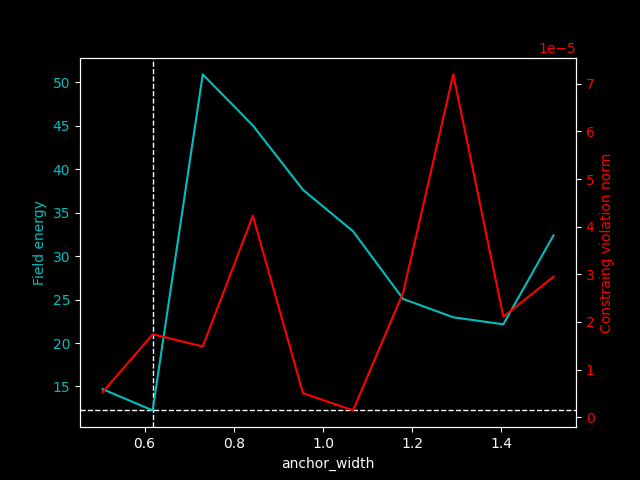

In [88]:
reload(efield)


def dipole(box1: efield.Box, box2: efield.Box, universe: efield.Box):
    box1_locations3d = box1.grid(2, 2, 2)
    box2_locations3d = box2.grid(2, 2, 2)

    conductor_locations3d = torch.vstack((box1_locations3d, box2_locations3d))
    conductor_potentials = torch.tensor(
        [-1.0] * len(box1_locations3d) + [1.0] * len(box2_locations3d),
    )

    test_locations3d = universe.grid(10, 10, 10)

    potential = efield.potential_function(
        test_locations3d, conductor_locations3d, conductor_potentials
    )

    return potential


box1 = efield.Box(-0.01, 0.01, -0.01, 0.01, -0.49, -0.51)
box2 = efield.Box(-0.01, 0.01, -0.01, 0.01, 0.49, 0.51)
universe = efield.Box(-0.5, 0.5, -0.5, 0.5, -1, 1)
potential = dipole(box1, box2, universe)

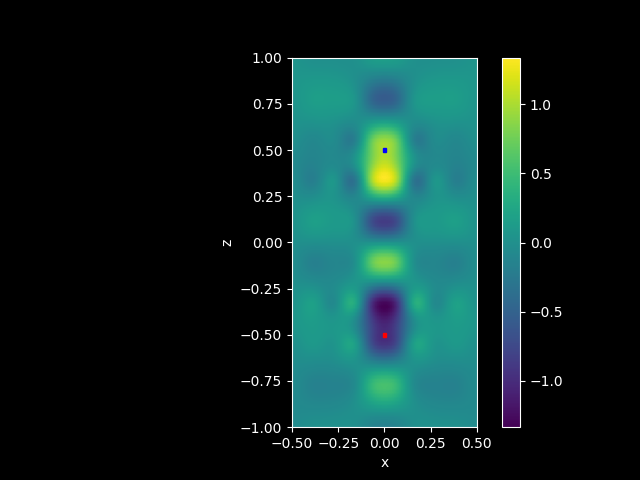

In [89]:
def show_xz_cross_section(
    box1: efield.Box,
    box2: efield.Box,
    universe: efield.Box,
    potential: efield.Potential,
    y: float,
):
    X, Z = torch.meshgrid(
        torch.linspace(universe.xmin, universe.xmax, 100),
        torch.linspace(universe.zmin, universe.zmax, 100),
        indexing="xy",
    )
    xyz = torch.stack((X.flatten(), X.flatten() * 0 + y, Z.flatten())).T

    V = potential(xyz).reshape(X.shape).detach()

    fig, ax = plt.subplots(1, 1)
    img = ax.imshow(
        V,
        extent=(universe.xmin, universe.xmax, universe.zmin, universe.zmax),
        origin="lower",
    )
    fig.colorbar(img, ax=ax)

    ax.add_artist(
        plt.Rectangle(
            (box1.xmin, box1.zmin),
            box1.xmax - box1.xmin,
            box1.zmax - box1.zmin,
            color="r",
        )
    )
    ax.add_artist(
        plt.Rectangle(
            (box2.xmin, box2.zmin),
            box2.xmax - box2.xmin,
            box2.zmax - box2.zmin,
            color="b",
        ),
    )
    ax.set_xlabel("x")
    ax.set_ylabel("z")


show_xz_cross_section(box1, box2, universe, potential, 0)

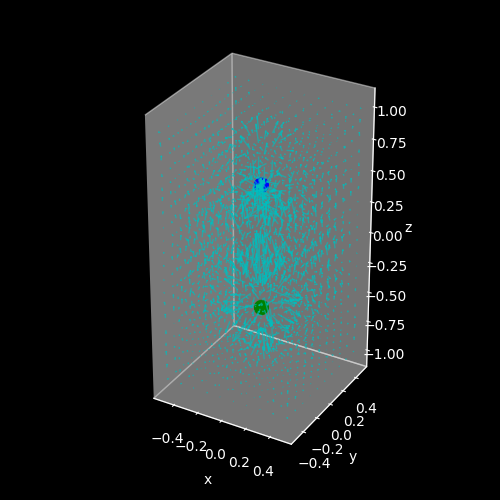

In [92]:
def show_field(
    pt1: torch.Tensor,
    pt2: torch.Tensor,
    universe: efield.Box,
    potential: efield.Potential,
):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")

    box1_locations3d = box1.grid(3, 3, 3)
    ax.scatter(
        box1_locations3d[:, 0],
        box1_locations3d[:, 1],
        box1_locations3d[:, 2],
        s=50,
        color="g",
    )
    box2_locations3d = box2.grid(3, 3, 3)
    ax.scatter(
        box2_locations3d[:, 0],
        box2_locations3d[:, 1],
        box2_locations3d[:, 2],
        s=50,
        color="b",
    )
    xyz = universe.grid(10, 10, 20)

    Vx, Vy, Vz = potential.field(xyz).detach()
    ax.quiver(
        xyz[:, 0],
        xyz[:, 1],
        xyz[:, 2],
        Vx,
        Vy,
        Vz,
        lw=1,
        length=0.1,
        alpha=0.6,
        color="c",
    )
    ax.grid(False)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.axis("square")


show_field(box1, box2, universe, potential)